In [16]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from mlpp.hawkesnoparam.estim import Estim
import mlpp.pp.hawkes as hk
import whma.simulation as simu
from mlpp.base.utils import TimeFunction
from whma.metrics import rel_err, rank_corr, mse_K_partial
from whma.cumulants import get_C, get_K_partial

In [17]:
# simulation of Hawkes processes
d = 10
mu = 0.0005 * np.ones(d)
mus = simu.simulate_mu(d, mu=mu)
blocks = [5,5]
Alpha_truth = np.zeros((d,d))
for i in range(5):
    for j in range(5):
        if i <= j:
            Alpha_truth[i][j] = 1.
for i in range(5,10):
    for j in range(5,10):
        if i >= j:
            Alpha_truth[i][j] = 1.
Alpha_truth /= 6
# add noise
#Alpha_truth += 0.01
blocks = [5,5]
L = []
L.append(np.ones((blocks[0],blocks[0])))
L.append(np.ones((blocks[1],blocks[1])))
Alpha_truth = scipy.linalg.block_diag(*L) / 6

In [18]:
hMax = 40
hDelta = .01
from math import log
beta_min = log(1000) / hMax
beta_max = log(10./9.) / hDelta
print("We have")
print("    beta_min = ",beta_min)
print("    beta_max = ",beta_max)

We have
    beta_min =  0.17269388197455343
    beta_max =  10.536051565782634


In [19]:
LL = []
LL.append(beta_max*np.ones((blocks[0],blocks[0])))
LL.append(beta_min*np.ones((blocks[1],blocks[1])))
Beta = scipy.linalg.block_diag(*LL)

In [20]:
_, s, _ = np.linalg.svd(Alpha_truth)
print(s.max())
assert s.max() < 1, "Alpha_truth cannot generate a stable Hawkes process"

0.833333333333


In [21]:
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha_truth, Beta)]
h = hk.Hawkes(kernels=kernels, mus=list(mus))
T_max = 10000
h.simulate(T_max)
estim = Estim(h, n_threads=8, hDelta=hDelta, hMax=hMax)

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


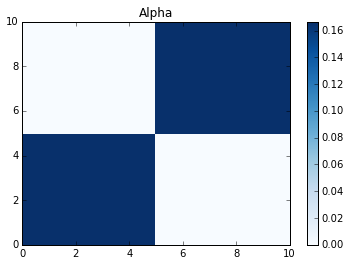

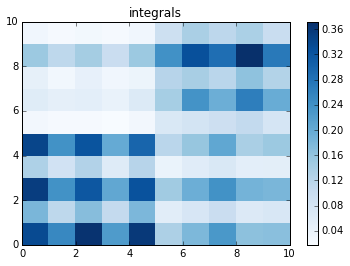

In [22]:
plt.pcolor(Alpha_truth,cmap=plt.cm.Blues)
plt.title("Alpha")
plt.colorbar()
plt.show()
plt.close()
plt.pcolor(np.array(estim.integrals),cmap=plt.cm.Blues)
plt.title("integrals")
plt.colorbar()
plt.show()
plt.close()

In [23]:
L = np.array(estim.lam)
C = get_C(estim)
K_partial = get_K_partial(L, C, np.array(estim.integrals))

In [24]:
objective = lambda R: mse_K_partial(L, C, K_partial, R)

In [25]:
from scipy.optimize import fmin_l_bfgs_b
res = fmin_l_bfgs_b(objective,np.eye(d),approx_grad=True)

In [26]:
res[1]

0.13808469935288478

In [27]:
R_final = res[0].reshape((d,d))
from scipy.linalg import inv
Phi_final = np.eye(d) - inv(R_final)

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


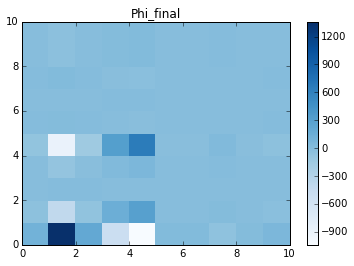

In [28]:
plt.pcolor(Phi_final,cmap=plt.cm.Blues)
plt.title("Phi_final")
plt.colorbar()
plt.show()
plt.close()